In [13]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

import numpy as np
from pythtb import *
from wpythtb import *
from models import *
import matplotlib.pyplot as plt
from functools import partial

%load_ext line_profiler
%timeit

/Users/treycole/Repos/WanPy/dev
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
def compute_d4k_and_d2k(delta_k):
    """
    Computes the 4D volume element d^4k and the 2D plaquette areas d^2k for a given set of difference vectors in 4D space.

    Parameters:
    delta_k (numpy.ndarray): A 4x4 matrix where each row is a 4D difference vector.

    Returns:
    tuple: (d4k, plaquette_areas) where
        - d4k is the absolute determinant of delta_k (4D volume element).
        - plaquette_areas is a dictionary with keys (i, j) and values representing d^2k_{ij}.
    """
    # Compute d^4k as the determinant of the 4x4 difference matrix
    d4k = np.abs(np.linalg.det(delta_k))

    # Function to compute 2D plaquette area in 4D space
    def compute_plaquette_area(v1, v2):
        """Compute the 2D plaquette area spanned by two 4D vectors."""
        area_squared = 0.0
        # Sum over all unique (m, n) pairs where m < n
        for m in range(4):
            for n in range(m + 1, 4):
                area_squared += (v1[m] * v2[n] - v1[n] * v2[m]) ** 2
        return np.sqrt(area_squared)

    # Compute all unique plaquette areas
    plaquette_areas = {}
    for i in range(4):
        for j in range(i + 1, 4):
            plaquette_areas[(i, j)] = compute_plaquette_area(delta_k[i], delta_k[j])

    return d4k, plaquette_areas

In [4]:
t = 2.0  # spin-independent first-neighbor hop
soc = 1  # spin-dependent second-neighbor hop
m = 1  # magnetic field magnitude
beta = 0
fkm_model = fu_kane_mele(t, soc, m, beta)

recip_lat_vecs = fkm_model.get_recip_lat_vecs()

nks = 20, 20, 20
n_beta = 50
n_param = nks + (n_beta,)
max_beta = 2*np.pi
betas = np.linspace(0, max_beta, n_beta, endpoint=False) # change to endpoint=False for periodic
fixed_params = {"t": 1.0, "soc": 1/4, "m": 1/2}
lambda_vals = {"beta": betas}
model_gen = partial(fu_kane_mele, **fixed_params)

print("Total number of parameter points: ", np.prod(n_param))

Total number of parameter points:  400000


In [5]:
bloch_states = Bloch(fkm_model, *n_param)
bloch_states.solve_model(model_fxn=model_gen, lambda_vals=lambda_vals)
bloch_states.set_pbc_lam()

u_wfs = bloch_states.get_states()["Cell periodic"]
n_occ = bloch_states._n_states//2

print(max_beta, bloch_states.pbc_lam)
print("Number of states:", bloch_states._n_states)
print("Number of occupied bands:", n_occ)
print("Shape of wf array:", u_wfs.shape)
print(bloch_states.get_wf_axes())

6.283185307179586 True
Number of states: 4
Number of occupied bands: 2
Shape of wf array: (20, 20, 20, 50, 4, 2, 2)
{'wf shape': (20, 20, 20, 50, 4, 2, 2), 'Number of axes': 7, 'k-axes': (0, 1, 2), 'lambda-axes': (3,), 'spin-axis': -1, 'orbital axis': -2, 'state axis': -3}


In [6]:
dim_k = bloch_states.dim_k   # Number of k-space dimensions
dim_lam = bloch_states.dim_lam  # Number of adiabatic dimensions
dim_total = bloch_states.dim_param  # Total number of dimensions

print(dim_k, dim_lam, dim_total)

# Construct delta_k with 4D embedding (extra zeros for adiabatic params)
delta_k = np.zeros((dim_k, dim_total))  # (3, dim_total)
delta_k[:, :dim_k] = recip_lat_vecs / np.array(bloch_states.nks)[:, None]
# Construct delta_lambda (embedding into 4D with zeros in k-space parts)
delta_lam = np.zeros((dim_lam, dim_total))  # (dim_lam, dim_total)
np.fill_diagonal(delta_lam[:, dim_k:], max_beta / np.array(bloch_states.n_lambda))

dk = np.vstack([delta_k, delta_lam])  # (dim_total, dim_total)
d4k = np.linalg.det(dk)

print("dk vectors: \n",dk)
print("det(dk) =", d4k)

3 1 4
dk vectors: 
 [[-0.15707963  0.15707963  0.15707963  0.        ]
 [ 0.15707963 -0.15707963  0.15707963  0.        ]
 [ 0.15707963  0.15707963 -0.15707963  0.        ]
 [ 0.          0.          0.          0.12566371]]
det(dk) = 0.0019481818206800502


In [8]:
# Compute d4k and d2k values
d4k, d2ks = compute_d4k_and_d2k(dk)

# Print results
print("d^4k (4D Volume Element):", d4k)
print("Plaquette Areas (d^2k):")
for key, value in d2ks.items():
    print(f"d^2k_{key} = {value}")

d^4k (4D Volume Element): 0.0019481818206800502
Plaquette Areas (d^2k):
d^2k_(0, 1) = 0.06978864199638879
d^2k_(0, 2) = 0.06978864199638879
d^2k_(0, 3) = 0.03418931254658434
d^2k_(1, 2) = 0.06978864199638879
d^2k_(1, 3) = 0.03418931254658434
d^2k_(2, 3) = 0.03418931254658434


In [32]:
# %lprun -f bloch_states.berry_flux_plaq bloch_states.berry_flux_plaq(state_idx=list(range(n_occ)), non_abelian=True)

In [9]:
b_curv, b_flux = bloch_states.berry_curv(state_idx=list(range(n_occ)), non_abelian=True, diff_lam=max_beta, return_flux=True)
# b_curv_abel = bloch_states.berry_curv(state_idx=list(range(n_occ)), non_abelian=False, diff_lam=max_beta, return_flux=False)

[[-0.15707963  0.15707963  0.15707963  0.        ]
 [ 0.15707963 -0.15707963  0.15707963  0.        ]
 [ 0.15707963  0.15707963 -0.15707963  0.        ]
 [ 0.          0.          0.          0.12566371]]
0 1
0 2
0 3
1 2
1 3
2 3
[[-0.15707963  0.15707963  0.15707963  0.        ]
 [ 0.15707963 -0.15707963  0.15707963  0.        ]]
0.06978864199638879
[[-0.15707963  0.15707963  0.15707963  0.        ]
 [ 0.15707963  0.15707963 -0.15707963  0.        ]]
0.06978864199638879
[[-0.15707963  0.15707963  0.15707963  0.        ]
 [ 0.          0.          0.          0.12566371]]
0.03418931254658432
[[ 0.15707963 -0.15707963  0.15707963  0.        ]
 [-0.15707963  0.15707963  0.15707963  0.        ]]
0.06978864199638879
[[ 0.15707963 -0.15707963  0.15707963  0.        ]
 [ 0.15707963  0.15707963 -0.15707963  0.        ]]
0.06978864199638879
[[ 0.15707963 -0.15707963  0.15707963  0.        ]
 [ 0.          0.          0.          0.12566371]]
0.03418931254658432
[[ 0.15707963  0.15707963 -0.1570

In [10]:
print("Max Berry flux:", np.max(np.abs(b_flux)))
print("Max Berry curvature:", np.max(np.abs(b_curv)))

Max Berry flux: 0.2937642559720288
Max Berry curvature: 4.209341915368258


In [11]:
recip_basis = recip_lat_vecs/ np.linalg.norm(recip_lat_vecs, axis=1, keepdims=True)
g = recip_basis @ recip_basis.T
sqrt_mtrc = np.sqrt(np.linalg.det(g))

delta_k = np.array([recip_lat_vecs[k_idx]/(nk) for k_idx, nk in enumerate(nks)]) 
dk1 = np.linalg.norm(recip_lat_vecs[0]/(nks[0]))
dk2 = np.linalg.norm(recip_lat_vecs[1]/(nks[1]))
dk3 = np.linalg.norm(recip_lat_vecs[2]/(nks[2]))
d_beta = max_beta/n_beta  # Step size for beta integration

d3k = np.linalg.det(delta_k)
d4k, d2ks = compute_d4k_and_d2k(dk) 
d3k_alt = np.prod([dk1, dk2, dk3])
d4k_alt = np.prod([dk1, dk2, dk3, d_beta])

print(dk1, dk2, dk3, d_beta)
print(sqrt_mtrc)
print(d3k_alt, d4k_alt)
print(d3k_alt*sqrt_mtrc, d4k_alt*sqrt_mtrc)
print(d3k, d4k)
print(fkm_model.get_recip_vol()/np.prod(nks))

0.27206990463513264 0.27206990463513264 0.27206990463513264 0.12566370614359174
0.7698003589195012
0.0201391674614315 0.0025307624218499124
0.015503138340149908 0.0019481818206800487
0.015503138340149915 0.0019481818206800502
0.015503138340149903


In [14]:
epsilon = levi_civita(4, 4)
chern2_density = np.einsum("ijkl, ij...mn, kl...nm->...", epsilon, b_curv, b_curv) 

chern2 = np.sum(chern2_density) * d4k / (32 * np.pi**2)
print("C2:", chern2.real)

C2: 0.7236193600231444


In [21]:
epsilon = levi_civita(4, 4)
chern2_density = np.einsum("ijkl, ij...mn, kl...nm->...", epsilon, b_flux, b_flux) 

chern2 = np.sum(chern2_density) / (32 * np.pi**2)
print("C2:", chern2.real)

C2: 0.8862491000280088


Text(0.5, 1.0, 'Plaquette method: Using curvature')

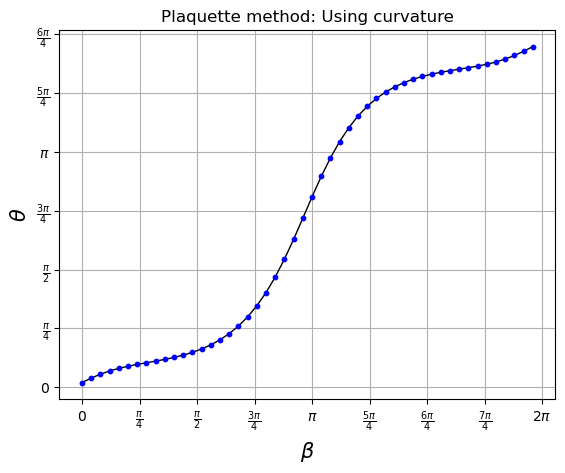

In [27]:
thetas = np.zeros(betas.shape[0], dtype=complex)

chern2_density = np.einsum("ijkl, ij...mn, kl...nm->...", epsilon, b_curv, b_curv)

for beta_idx, beta in enumerate(betas):
    sliced_dtheta = chern2_density[..., :beta_idx+1]

    theta = np.sum(sliced_dtheta) * d4k
    
    thetas[beta_idx] = theta / (16 * np.pi)

#### Plotting theta(beta)

fig, ax = plt.subplots()

ax.set_xlabel(r"$\beta$", size=15)
ax.set_ylabel(r"$\theta$", size=15)

tick_positions = np.arange(0, 2*np.pi+np.pi/4, np.pi/4)
tick_labels = [
    r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$", 
    r"$\frac{5\pi}{4}$", r"$\frac{6\pi}{4}$", r"$\frac{7\pi}{4}$", r"$2\pi$"]

# Set the ticks and labels for both axes
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

# ax.set_ylim(0, np.pi+.02)
# ax.set_xlim(0, np.pi+0.02)

ax.plot(betas, thetas.real, lw=1, zorder=2, c='k')  
ax.scatter(betas, thetas.real, s=10, zorder=2, c='b')
ax.grid()
ax.set_title("Plaquette method: Using curvature")

Text(0.5, 1.0, 'Plaquette method: Using flux')

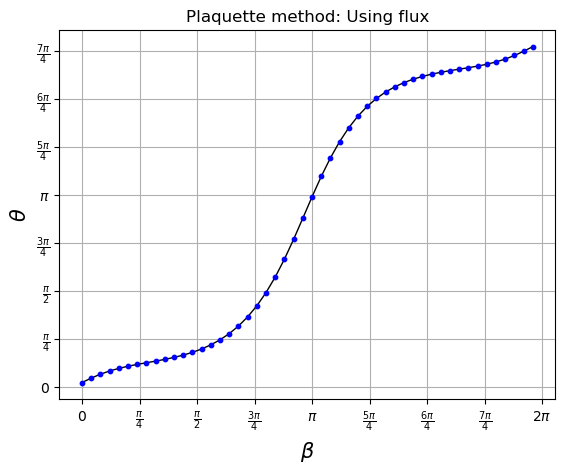

In [28]:
thetas = np.zeros(betas.shape[0], dtype=complex)

chern2_density = np.einsum("ijkl, ij...mn, kl...nm->...", epsilon, b_flux, b_flux)

for beta_idx, beta in enumerate(betas):
    sliced_dtheta = chern2_density[..., :beta_idx+1]

    theta = np.sum(sliced_dtheta) 
    
    thetas[beta_idx] = theta / (16 * np.pi)


#### Plotting theta(beta)

fig, ax = plt.subplots()

ax.set_xlabel(r"$\beta$", size=15)
ax.set_ylabel(r"$\theta$", size=15)

tick_positions = np.arange(0, 2*np.pi+np.pi/4, np.pi/4)
tick_labels = [
    r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$", 
    r"$\frac{5\pi}{4}$", r"$\frac{6\pi}{4}$", r"$\frac{7\pi}{4}$", r"$2\pi$"]

# Set the ticks and labels for both axes
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

# ax.set_ylim(0, np.pi+.02)
# ax.set_xlim(0, np.pi+0.02)

ax.plot(betas, thetas.real, lw=1, zorder=2, c='k')  
ax.scatter(betas, thetas.real, s=10, zorder=2, c='b')
ax.grid()
ax.set_title("Plaquette method: Using flux")

In [179]:
chern2_density[1,1,1, 28]

np.complex128(-0.0008939395609442095-2.979653954882076e-16j)

In [36]:
thetas[-12]

np.complex128(2.1136079023263306-7.929660727911628e-16j)